<a href="https://colab.research.google.com/github/Finkovski/Project2-G2/blob/main/Project2_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

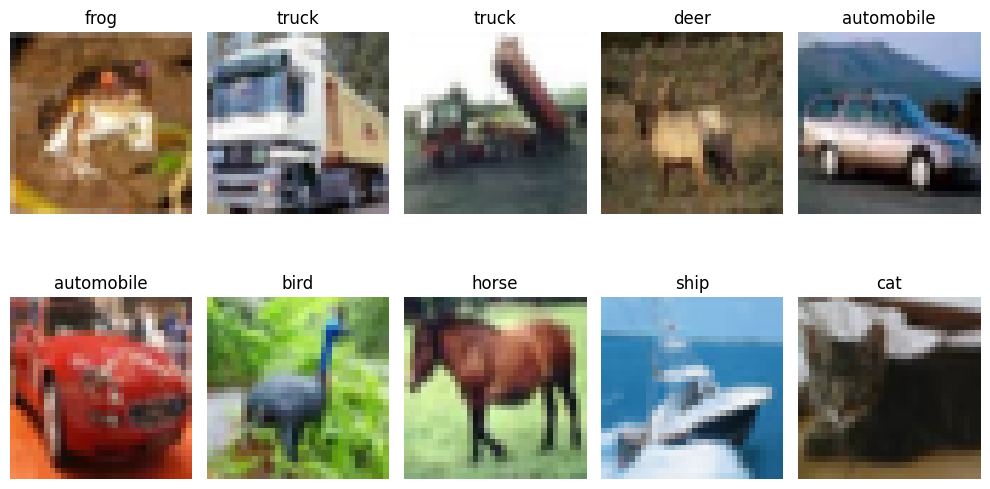

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(10):
    img = x_train[i]
    label = class_names[y_train[i][0]]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - accuracy: 0.6931 - loss: 0.9067 - val_accuracy: 0.8038 - val_loss: 0.5643
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - accuracy: 0.7956 - loss: 0.5927 - val_accuracy: 0.8145 - val_loss: 0.5433
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8118 - loss: 0.5447 - val_accuracy: 0.8143 - val_loss: 0.5319
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.8237 - loss: 0.5086 - val_accuracy: 0.8232 - val_loss: 0.5169
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8313 - loss: 0.4863 - val_accuracy: 0.8252 - val_loss: 0.5223
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8369 - loss: 0.4663 - val_accuracy: 0.8267 - val_loss: 0.5089
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.8459 - loss: 0.4385 - val_accuracy: 0.8319 - val_loss: 0.5054
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8496 -

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8293 - loss: 0.5073
Test Accuracy: 0.8343


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step
              precision    recall  f1-score   support

    airplane       0.89      0.83      0.86      1000
  automobile       0.92      0.91      0.91      1000
        bird       0.80      0.79      0.80      1000
         cat       0.66      0.73      0.69      1000
        deer       0.81      0.76      0.78      1000
         dog       0.81      0.72      0.77      1000
        frog       0.86      0.88      0.87      1000
       horse       0.82      0.89      0.85      1000
        ship       0.88      0.92      0.90      1000
       truck       0.90      0.91      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



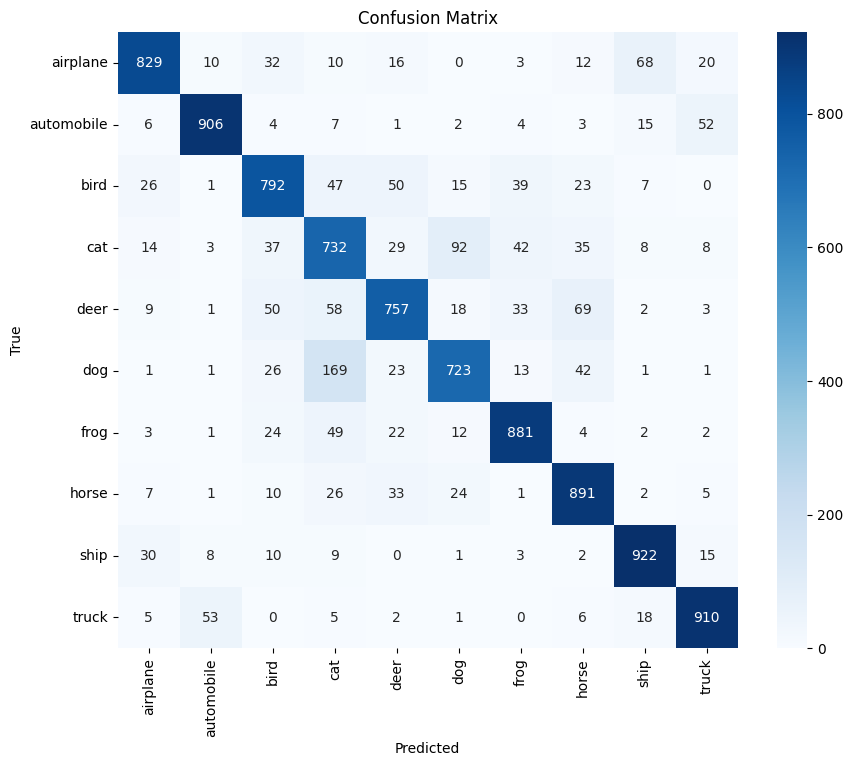

In [ ]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
model.save('cifar10_transfer_model.keras')

In [ ]:
# Unfreeze from layer 100 onwards (out of ~154)
UNFREEZE_FROM = 100

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers before `UNFREEZE_FROM`
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= UNFREEZE_FROM


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.7016 - loss: 1.2034 - val_accuracy: 0.8495 - val_loss: 0.4873
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8128 - loss: 0.5545 - val_accuracy: 0.8597 - val_loss: 0.4388
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.8526 - loss: 0.4364 - val_accuracy: 0.8686 - val_loss: 0.4105
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.8733 - loss: 0.3729 - val_accuracy: 0.8758 - val_loss: 0.3844
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8906 - loss: 0.3130 - val_accuracy: 0.8822 - val_loss: 0.3669
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9037 - loss: 0.2770 - val_accuracy: 0.8844 - val_loss: 0.3611
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9110 - loss: 0.2453 - val_accuracy: 0.8864 - val_loss: 0.3631
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9261 -

In [ ]:
model.save('cifar10_transfer_model.keras')

In [ ]:
pip install --upgrade gradio

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model("cifar10_transfer_model.keras")

# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

IMG_SIZE = 160  # or 224 if you used VGG16

def predict(image):
    # Resize and preprocess
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)[0]
    result = {class_names[i]: float(preds[i]) for i in range(10)}
    return result

# Gradio Interface
app = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="CIFAR-10 Image Classifier",
    description="Upload a CIFAR-like image and get predictions with class probabilities."
)

# Launch the app
app.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fecec6cb51659cd7c0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
